In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize(mean=(.5), std=(.5))
])

trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
    
    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.log_softmax(self.fc4(x), dim=1)
        return x

Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw


Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw


Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


### Trials before training

In [ ]:
model = Classifier()

images, labels = next(iter(trainloader))
ps = torch.exp(model(images)) # get softmax probabilities
ps.shape

torch.Size([64, 10])

We are getting 10 columns ie one softmax probability per label


In [ ]:
top_p, top_class = ps.topk(1, dim=1) # returns the prob and index of the top k values (here top 1)
# Check for the first 10 examples
print(top_class[:10, :]) # [first ten rows, all columns]

tensor([[5],
        [5],
        [5],
        [5],
        [5],
        [5],
        [5],
        [5],
        [5],
        [5]])


## Training

In [ ]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 30
steps = 0
train_losses = []
test_losses = []

for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        optimizer.zero_grad()
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    else:
        # Else block executes once per completion of all the iteration of the for loop above
        test_loss = 0
        accuracy = 0
        # turn off gradients for validation
        with torch.no_grad():
            for images, labels in testloader:
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)
                ps = torch.exp(log_ps) # softmax from logits
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

Epoch: 1/30..  Training Loss: 0.518..  Test Loss: 0.416..  Test Accuracy: 0.848
Epoch: 2/30..  Training Loss: 0.377..  Test Loss: 0.406..  Test Accuracy: 0.852
Epoch: 3/30..  Training Loss: 0.338..  Test Loss: 0.365..  Test Accuracy: 0.870
Epoch: 4/30..  Training Loss: 0.311..  Test Loss: 0.363..  Test Accuracy: 0.870
Epoch: 5/30..  Training Loss: 0.294..  Test Loss: 0.342..  Test Accuracy: 0.877
Epoch: 6/30..  Training Loss: 0.278..  Test Loss: 0.339..  Test Accuracy: 0.879
Epoch: 7/30..  Training Loss: 0.264..  Test Loss: 0.345..  Test Accuracy: 0.876
Epoch: 8/30..  Training Loss: 0.248..  Test Loss: 0.367..  Test Accuracy: 0.869
Epoch: 9/30..  Training Loss: 0.238..  Test Loss: 0.352..  Test Accuracy: 0.880
Epoch: 10/30..  Training Loss: 0.229..  Test Loss: 0.345..  Test Accuracy: 0.887
Epoch: 11/30..  Training Loss: 0.219..  Test Loss: 0.348..  Test Accuracy: 0.887
Epoch: 12/30..  Training Loss: 0.211..  Test Loss: 0.335..  Test Accuracy: 0.889
Epoch: 13/30..  Training Loss: 0.203.

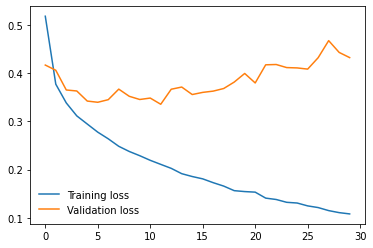

In [ ]:
%matplotlib inline
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

It's overfitting (My greatest nemesis, we meet again!)

Epoch: 1/30..  Training Loss: 0.608..  Test Loss: 0.484..  Test Accuracy: 0.833
Epoch: 2/30..  Training Loss: 0.488..  Test Loss: 0.437..  Test Accuracy: 0.842
Epoch: 3/30..  Training Loss: 0.453..  Test Loss: 0.431..  Test Accuracy: 0.849
Epoch: 4/30..  Training Loss: 0.431..  Test Loss: 0.409..  Test Accuracy: 0.853
Epoch: 5/30..  Training Loss: 0.421..  Test Loss: 0.398..  Test Accuracy: 0.859
Epoch: 6/30..  Training Loss: 0.412..  Test Loss: 0.377..  Test Accuracy: 0.867
Epoch: 7/30..  Training Loss: 0.405..  Test Loss: 0.405..  Test Accuracy: 0.857
Epoch: 8/30..  Training Loss: 0.398..  Test Loss: 0.397..  Test Accuracy: 0.858
Epoch: 9/30..  Training Loss: 0.399..  Test Loss: 0.399..  Test Accuracy: 0.857
Epoch: 10/30..  Training Loss: 0.388..  Test Loss: 0.386..  Test Accuracy: 0.867
Epoch: 11/30..  Training Loss: 0.384..  Test Loss: 0.379..  Test Accuracy: 0.870
Epoch: 12/30..  Training Loss: 0.381..  Test Loss: 0.396..  Test Accuracy: 0.864
Epoch: 13/30..  Training Loss: 0.381.

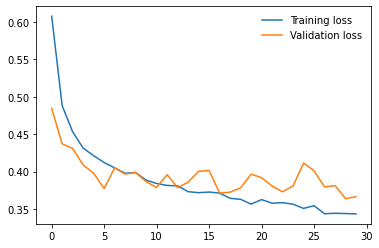

In [ ]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)

        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        x = x.view(x.shape[0], -1)

        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        x = F.log_softmax(self.fc4(x), dim=1)
        return x

model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)
epochs = 30
steps = 0

train_losses, test_losses = [], []

for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        optimizer.zero_grad()

        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    else:
        test_loss = 0
        accuracy = 0

        # turn off gradients
        with torch.no_grad():
            model.eval() # setting model to evaluation mode to prevent dropout during validation/inference
            for images, labels in testloader:
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)

                ps = torch.exp(log_ps) # raw prob instead of log probs
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        model.train() # setting back to training mode, turning dropout back on
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))
        
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

In [ ]:
# https://github.com/udacity/deep-learning-v2-pytorch/blob/master/intro-to-pytorch/helper.py
def view_classify(img, ps, version="MNIST"):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    if version == "MNIST":
        ax2.set_yticklabels(np.arange(10))
    elif version == "Fashion":
        ax2.set_yticklabels(['T-shirt/top',
                            'Trouser',
                            'Pullover',
                            'Dress',
                            'Coat',
                            'Sandal',
                            'Shirt',
                            'Sneaker',
                            'Bag',
                            'Ankle Boot'], size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()



## Model Inference

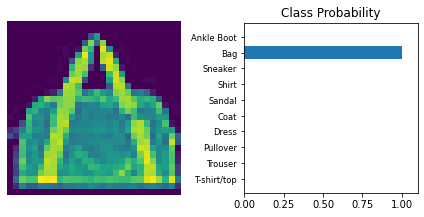

In [ ]:
# Test out your network!

model.eval()

dataiter = iter(testloader)
images, labels = dataiter.next()
img = images[0]
# Convert 2D image to 1D vector
img = img.view(1, 784)

# Calculate the class probabilities (softmax) for img
with torch.no_grad():
    output = model.forward(img)

ps = torch.exp(output)

# Plot the image and probabilities
view_classify(img.view(1, 28, 28), ps, version='Fashion')

## Saving and Loading the Model

The parameters for PyTorch networks are stored in a model's state_dict. We can see the state dict contains the weight and bias matrices for each of our layers.

In [ ]:
print(model)

Classifier(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [ ]:
print(type(model.state_dict()))
print(model.state_dict().keys())

<class 'collections.OrderedDict'>
odict_keys(['fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias', 'fc4.weight', 'fc4.bias'])


In [ ]:
print(model.state_dict()['fc1.weight'])

tensor([[ 0.3008,  0.2932,  0.2927,  ...,  0.3808,  0.3484,  0.3346],
        [ 0.2416,  0.2840,  0.2202,  ...,  0.2554,  0.2827,  0.2509],
        [ 0.0412,  0.0347,  0.0656,  ...,  0.0120,  0.0243,  0.0489],
        ...,
        [ 0.0833,  0.0425,  0.0906,  ...,  0.0884,  0.2004,  0.0748],
        [ 0.0563,  0.0816,  0.0125,  ...,  0.0228, -0.0115,  0.0567],
        [ 0.1245,  0.1422,  0.1974,  ...,  0.1516,  0.1105,  0.1569]])


In [ ]:
print(model.state_dict()['fc1.bias'])

tensor([-0.3252, -0.2989, -0.0525, -0.0780, -0.2208, -0.1977, -0.0147, -0.2239,
        -0.0547,  0.0338, -0.4430, -0.3806, -0.1467, -0.3854, -0.0461, -0.0679,
        -0.0981, -0.0725, -0.0595, -0.0569, -0.0555, -0.2095, -0.1094, -0.2521,
        -0.0252, -0.0451, -0.2293, -0.0752, -0.3522, -0.4472, -0.3958, -0.0455,
        -0.0680, -0.3999, -0.0413, -0.0607, -0.0391, -0.3028,  0.0082, -0.2333,
        -0.0577, -0.0995, -0.0041, -0.1012, -0.1348, -0.0775, -0.1795, -0.4969,
        -0.1479, -0.0562, -0.1672, -0.1742, -0.2999, -0.2075, -0.3147, -0.0471,
        -0.3334, -0.2461, -0.2495, -0.0393, -0.0769, -0.1451, -0.0973, -0.2900,
        -0.0296, -0.0955, -0.2738, -0.1522, -0.3725,  0.1272, -0.2561, -0.2505,
        -0.1662, -0.3345, -0.1665, -0.2507, -0.0997, -0.3084, -0.0656, -0.3367,
        -0.1537, -0.1430, -0.2034, -0.1082, -0.2045, -0.0541, -0.4163, -0.3780,
        -0.2829, -0.1366, -0.1265, -0.1753, -0.1582, -0.2218, -0.2371, -0.0286,
        -0.0073, -0.3792, -0.1238, -0.23

### Use torch.save() to save the model

Save the model's state_dictionary

In [ ]:
torch.save(model.state_dict(), 'checkpoint.pth')

In [ ]:
# Load the state dict with torch.load()
state_dict = torch.load('checkpoint.pth')
print(state_dict.keys())

odict_keys(['fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias', 'fc4.weight', 'fc4.bias'])


In [ ]:
# now, to load state dict into the network, use model.load_state_dict()
model.load_state_dict(state_dict)
# Note that the model architecture should be exactly the same as the checkpoint's architecture

<All keys matched successfully>

In [ ]:
# if we do not have the object model beforehand, make it
checkpoint = {'input_size': 784,
              'output_size': 10,
              'hidden_layers': [each.out_features for each in [model.fc1, model.fc2, model.fc3]],
              'state_dict': model.state_dict()}
torch.save(checkpoint, 'checkpoint.pth')

Linear(in_features=784, out_features=256, bias=True)